In [473]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from tsmoothie.smoother import LowessSmoother
import itertools

In [474]:
nyc_taxi = pd.read_csv('../data/nyc_taxi.csv', index_col='timestamp', parse_dates=True)
nyc_taxi_orig = nyc_taxi.copy()

# Feature Engineering

We get the most mileage out of turning the timestamp into a variety of columns. We can also shift the values so that each timestamp also has the value of the previous day and week. There's labels for this data showing 5 data points that are anomalous, and we add those. The amount of anomaly points is tiny so in the end we end up performing unsupervised learning.

In [475]:
time_map = {dt.time(0,0): 0, dt.time(0,30): 1
           ,dt.time(1,0): 2, dt.time(1,30): 3
           ,dt.time(2,0): 4, dt.time(2,30): 5
           ,dt.time(3,0): 6, dt.time(3,30): 7
           ,dt.time(4,0): 8, dt.time(4,30): 9
           ,dt.time(5,0): 10, dt.time(5,30): 11
           ,dt.time(6,0): 12, dt.time(6,30): 13
           ,dt.time(7,0): 14, dt.time(7,30): 15
           ,dt.time(8,0): 16, dt.time(8,30): 17
           ,dt.time(9,0): 18, dt.time(9,30): 19
           ,dt.time(10,0): 20, dt.time(10,30): 21
           ,dt.time(11,0): 22, dt.time(11,30): 23
           ,dt.time(12,0): 24, dt.time(12,30): 25
           ,dt.time(13,0): 26, dt.time(13,30): 27
           ,dt.time(14,0): 28, dt.time(14,30): 29
           ,dt.time(15,0): 30, dt.time(15,30): 31
           ,dt.time(16,0): 32, dt.time(16,30): 33
           ,dt.time(17,0): 34, dt.time(17,30): 35
           ,dt.time(18,0): 36, dt.time(18,30): 37
           ,dt.time(19,0): 38, dt.time(19,30): 39
           ,dt.time(20,0): 40, dt.time(20,30): 41
           ,dt.time(21,0): 42, dt.time(21,30): 43
           ,dt.time(22,0): 44, dt.time(22,30): 45
           ,dt.time(23,0): 46, dt.time(23,30): 47}

nyc_taxi['time'] = nyc_taxi.index.time
nyc_taxi['time'] = nyc_taxi['time'].map(time_map)
nyc_taxi['dayofweek'] = nyc_taxi.index.weekday # Monday = 0
nyc_taxi['day'] = nyc_taxi.index.day
nyc_taxi['month'] = nyc_taxi.index.month
nyc_taxi['year'] = nyc_taxi.index.year

In [476]:
previous_day = nyc_taxi['value'].shift(48)
previous_day.fillna(nyc_taxi['value'], inplace=True)

previous_week = nyc_taxi['value'].shift(48 * 7)
previous_week.fillna(nyc_taxi['value'], inplace=True)

nyc_taxi['prev_day'] = previous_day
nyc_taxi['prev_week'] = previous_week

In [477]:
half_hour_forward = nyc_taxi['value'].shift(1)
half_hour_forward.fillna(nyc_taxi['value'], inplace=True)
half_hour_diff = half_hour_forward - nyc_taxi['value']


nyc_taxi['prev_30_diff'] = half_hour_diff
nyc_taxi['prev_day_diff'] = nyc_taxi['value'] - nyc_taxi['prev_day']
nyc_taxi['prev_week_diff'] = nyc_taxi['value'] - nyc_taxi['prev_week']

In [478]:
# The anomalies are 
# 2014-11-01 19:00:00
# 2014-11-27 15:30:00
# 2014-12-25 15:00:00
# 2015-01-01 01:00:00
# 2015-01-27 00:00:00

nyc_taxi['anomaly'] =  pd.Series([0] * len(nyc_taxi), index=nyc_taxi.index)

nyc_taxi.loc[['2014-11-01 19:00:00', '2014-11-27 15:30:00', 
              '2014-12-25 15:00:00', '2015-01-01 01:00:00', 
              '2015-01-27 00:00:00'], 'anomaly'] = 1

# Data Exploration

Here various graphs are generated to look for patterns in the data.

This graph is a histogram that is trying to bin the values for every 500. We see two local maxima at around 2,500 and 17,500.

<AxesSubplot:>

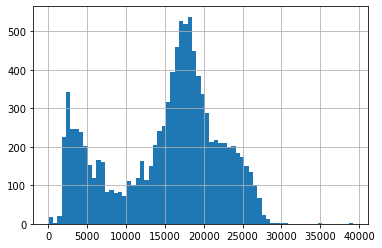

In [479]:
nyc_taxi['value'].hist(bins=70)

Here we plot out a couple weeks without an anomaly and a clear 24 hour pattern is forming. Looking closer, we can also see a weekly pattern emerging. Check out between 09/07 - 09/08 and 09/14 - 09/15. These are a week apart and are slighly different than the other days. 

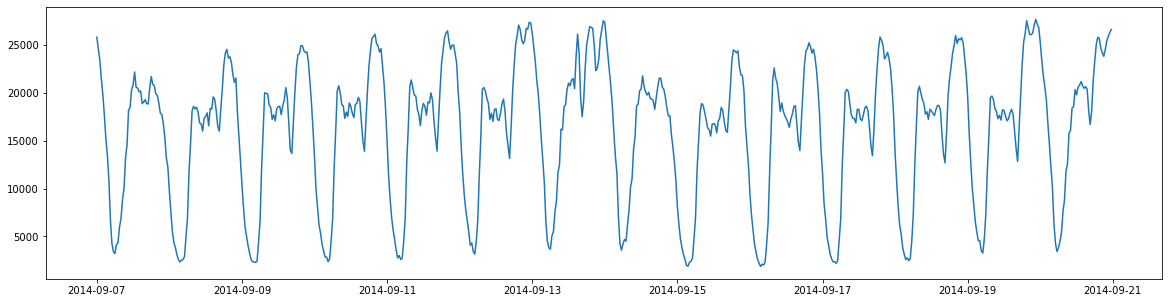

In [480]:
plt.figure(figsize=(20,5))
plt.plot(nyc_taxi.loc['2014-9-07 00:00:00':'2014-9-20 23:30:00','value'])

In [481]:
def plothour(h):
    plt.figure(figsize=(20,5))
    plt.plot(nyc_taxi[(nyc_taxi['time'] == h) & (nyc_taxi['dayofweek'] == 0)]['value'], 'bo')
    plt.plot(nyc_taxi[(nyc_taxi['time'] == h) & (nyc_taxi['dayofweek'] == 1)]['value'], 'ro')
    plt.plot(nyc_taxi[(nyc_taxi['time'] == h) & (nyc_taxi['dayofweek'] == 2)]['value'], 'go')
    plt.plot(nyc_taxi[(nyc_taxi['time'] == h) & (nyc_taxi['dayofweek'] == 3)]['value'], 'mo')
    plt.plot(nyc_taxi[(nyc_taxi['time'] == h) & (nyc_taxi['dayofweek'] == 4)]['value'], 'ko')
    plt.plot(nyc_taxi[(nyc_taxi['time'] == h) & (nyc_taxi['dayofweek'] == 5)]['value'], 'yo')
    plt.plot(nyc_taxi[(nyc_taxi['time'] == h) & (nyc_taxi['dayofweek'] == 6)]['value'], 'co')
    plt.plot(nyc_taxi[(nyc_taxi['time'] == h) ]['value'].rolling(7).mean().fillna(method='bfill'), 'orange')

By far the most interesting set of graphs are the ones generated by above code. They show a clearer picture of the role day of the week plays into which events should be considered anomalous. Also it's worth noting that there are some other days that one could argue are anomalous. Those would be: 7/4 Independence Day, 9/1 Labor Day, 11/29 Black Friday, and 12/24 Christmas Eve.

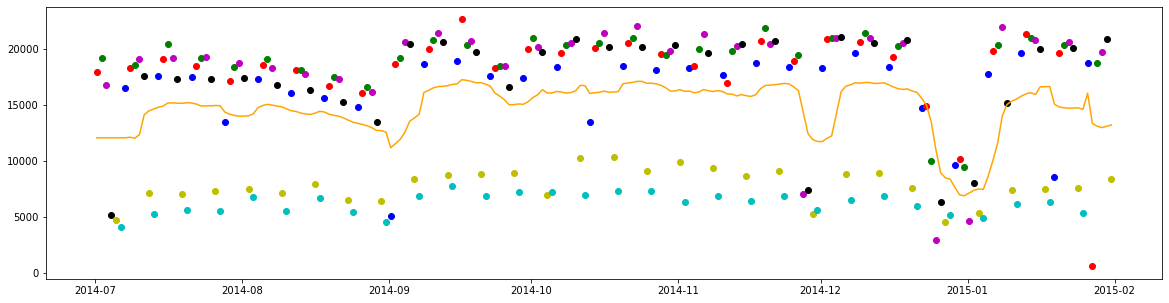

In [482]:
plothour(16) # 8:30 am

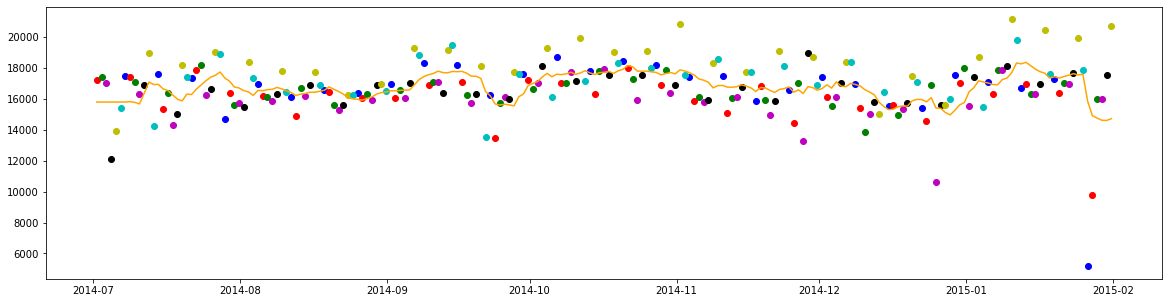

In [483]:
plothour(34) #5:00 pm

# What kind of problem is this?
## Classification
We want to be able to tell when a data point is or isn't an anomaly.

## Time Series
Our data is cyclical both by the day of the week and time of day. This gives us avenues towards separating the data into chunks based on the day of the week or what time slot they fall into. 

To find anomalies, our model separates the data into what hour of the day it is and what day of the week it is and then performs smoothing on that data. It picks out data points that do not fit into a predicted range and return those as anomalous points. This method takes advantage of the weekly similarity between times but doesn't take into account the times immediately before an hour. 

The model is based on the library shown in this article:
https://towardsdatascience.com/real-time-time-series-anomaly-detection-981cf1e1ca13

In [490]:
def find_anomalies(h, d):
    smoother = LowessSmoother(smooth_fraction=.6)
    smoother.smooth(nyc_taxi[(nyc_taxi['time'] == h) & (nyc_taxi['dayofweek'] == d)]['value'])
    
    low, up = smoother.get_intervals('prediction_interval')
    lower_bound = pd.Series(low[0], index=nyc_taxi[(nyc_taxi['time'] == h) & (nyc_taxi['dayofweek'] == d)]['value'].index)
    upper_bound = pd.Series(up[0], index=nyc_taxi[(nyc_taxi['time'] == h) & (nyc_taxi['dayofweek'] == d)]['value'].index)
   
    anomalies = []
    for i in upper_bound.index:
        if nyc_taxi['value'][i] < lower_bound[i] or nyc_taxi['value'][i] > upper_bound[i]:
            anomalies.append(i)
            
    return anomalies

In [487]:
all_anomalies = []
for h, d in itertools.product(range(0,48), range(0,6)):
    all_anomalies+=find_anomalies(h, d)


In [488]:
all_anomalies.sort()
all_anomalies

[Timestamp('2014-07-04 08:30:00'),
 Timestamp('2014-07-04 09:00:00'),
 Timestamp('2014-07-04 09:30:00'),
 Timestamp('2014-07-04 10:00:00'),
 Timestamp('2014-07-04 10:30:00'),
 Timestamp('2014-07-04 12:30:00'),
 Timestamp('2014-07-04 17:00:00'),
 Timestamp('2014-07-04 17:30:00'),
 Timestamp('2014-07-04 18:00:00'),
 Timestamp('2014-07-04 18:30:00'),
 Timestamp('2014-07-04 19:00:00'),
 Timestamp('2014-07-04 19:30:00'),
 Timestamp('2014-07-23 14:00:00'),
 Timestamp('2014-09-01 00:00:00'),
 Timestamp('2014-09-01 00:30:00'),
 Timestamp('2014-09-01 01:00:00'),
 Timestamp('2014-09-01 01:30:00'),
 Timestamp('2014-09-01 02:00:00'),
 Timestamp('2014-09-01 02:30:00'),
 Timestamp('2014-09-01 03:00:00'),
 Timestamp('2014-09-01 03:30:00'),
 Timestamp('2014-09-01 04:00:00'),
 Timestamp('2014-09-01 04:30:00'),
 Timestamp('2014-09-01 05:30:00'),
 Timestamp('2014-09-01 06:00:00'),
 Timestamp('2014-09-01 06:30:00'),
 Timestamp('2014-09-01 07:00:00'),
 Timestamp('2014-09-01 07:30:00'),
 Timestamp('2014-09-

In [489]:
len(all_anomalies)

428

# Conclusion

In conclusion, the model classifies way more points as anomalies than the labels suggest. However, it does pick out all of the anomalous points and usually picks out points around them that are also much different than the rest of the data. An interesting way to refine this model is to find a way to introduce the data immediately before each time point, so that after an anomaly is found, it is considered "the new normal" and similar points immediately after it won't be classified as anomalies.